# refinement of f(cosmic)

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [17]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/fCosmic_refinement/'

In [3]:
versions['data date'] = '2018_05_11'
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'

OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
print "%d"%len(OverlaySamples['cosmic'])+' cosmic pairs and %d'%len(OverlaySamples['1mu-1p'])+' mu-p pairs in overlay'

38163 pairs from On-Beam, 24323 in Fiducial Volume
283762 pairs from MC-BNB + cosmic DATA overlay
186485 pairs in FV
49707 are 1mu-1p, 26.7%
41519 are other pairs, 22.3%
95259 are cosmic, 51.1%
--------------------------------------------------------------
23996 are CC 1p 0pi, 12.9%
95259 cosmic pairs and 49707 mu-p pairs in overlay


In [7]:
cuts_order  = ['no cut'
               ,'MatchedFlash'               
              ]
cutlabels = ['preselection'
             ,'optical filter'
            ]

reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
pureffOverlay

,$\mu p$ eff.,$\mu p$ pur.,CC$0\pi 1 p$ eff.,CC$0\pi 1 p$ pur.,label,1mu-1p,other pairs,cosmic,CC 1p 0pi
no cut,100.0%,26.7%,100.0%,12.9%,no cut,100.0% (49707),100.0% (41519),100.0% (95259),100.0% (23996)
MatchedFlash,80.9%,39.6%,81.4%,19.2%,MatchedFlash,80.9% (40210),73.0% (30305),32.6% (31032),81.4% (19527)


In [22]:
reducedOnBeam,_ = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'done applying cuts to data'

done applying cuts to data


## 2.II Changing the cosmic to beam ratio in overlay after PMT cuts

In [82]:
var='theta_12'
x_label=r'$\theta_{1,2}$ angle between the two tracks [deg.]'
bins=np.linspace(0,180,51)

# overlay subsamples-scaling

In [83]:
overlay_scalings = dict()
overlay_scalings['N(On) scaling'] = get_samples_scaling( N_total= float(len(OnBeamFV)) # total integral of all overlay                                                                              
                                                        , f_Cosmic=None  # fraction of cosmic in the overlay, need to be in the range 0-1
                                                        , OverlaySubsamples=reducedOverlay['no cut'])

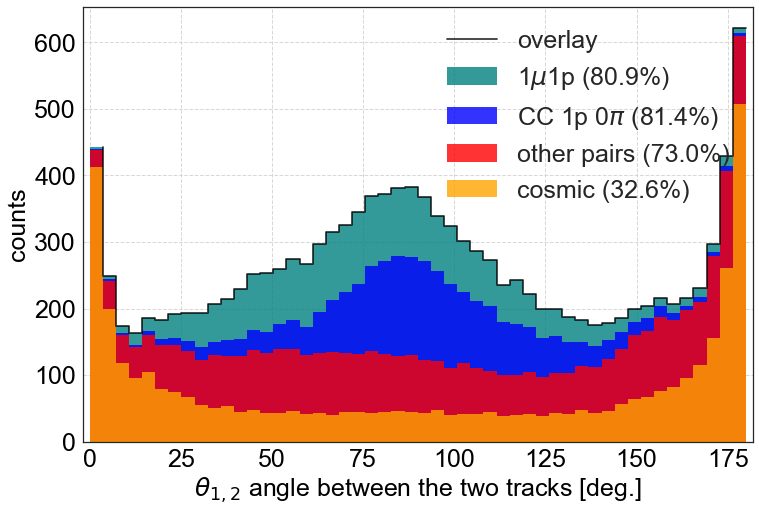

In [84]:
fig,ax=plt.subplots(figsize=(12,8))
plot_stacked_MCsamples( reducedOverlay=reducedOverlay,cut_name='MatchedFlash'
                       , overlay_scaling=overlay_scalings['N(On) scaling']
                       , ax=ax, var=var, x_label=x_label,y_label='counts', bins=bins 
                       , fontsize=25                       
                       , do_add_legend=True, stackColor='black',stackLabel='overlay'
                      );
plt.savefig(figures_path+'theta_12_overlay_stacked_MatchedFlash.pdf')

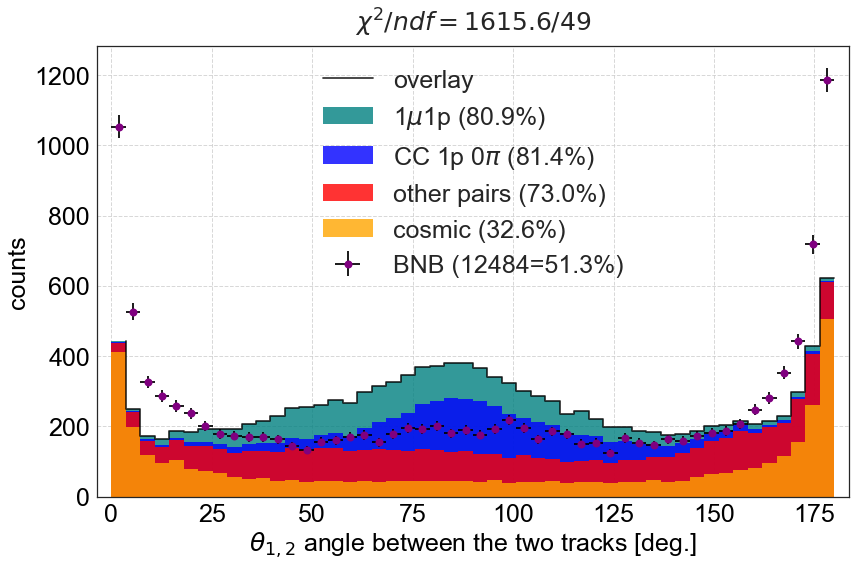

In [85]:
fig,ax=plt.subplots(figsize=(12,8))
h_stack,_=plot_stacked_MCsamples( reducedOverlay=reducedOverlay,cut_name='MatchedFlash'
                       , overlay_scaling=overlay_scalings['N(On) scaling']
                       , ax=ax, var=var, x_label=x_label,y_label='counts', bins=bins 
                       , fontsize=25                       
                       , stackColor='black',stackLabel='overlay'
                      );
_,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam['MatchedFlash'],OnBeamFV=OnBeamFV,markersize=8
                                 ,color='purple',x_label=x_label, var=var, bins=bins, ax=ax)
ax.legend(fontsize=25)
chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                     , h1=h_OnBeam , h2=h_stack
                                     , h1err=np.sqrt(h_OnBeam), h2err=np.sqrt(h_stack)
                                     , debug=0 )
chi2_txt = r'$\chi^2/ndf=%.1f/%d$'%(chi2,ndf)
ax.set_title(chi2_txt,y=1.02,fontsize=25)
plt.tight_layout()
plt.savefig(figures_path+'theta_12_overlay_stacked_MatchedFlash_with_BeamOn.pdf')

## optimize the matching using $\chi^2$ test

In [87]:
f_cosmic_array = linspace(0,1,50)
chi2_array = []

for f_Cosmic in f_cosmic_array:

    overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total= float(len(reducedOnBeam['MatchedFlash']))
                                                                                        , debug=0
                                                                                        , f_Cosmic=f_Cosmic
                                                                                        , OverlaySubsamples=reducedOverlay['MatchedFlash'])
    overlay_scaling = overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic]
    
    x = reducedOnBeam['MatchedFlash'][var]
    h_OnBeam,edges = np.histogram( x , bins=bins )
    h = dict()
    for i_pair_type,pair_type in enumerate(pair_types):
        sample = reducedOverlay['MatchedFlash'][pair_type]
        x = sample[var]; x = x[x<1e5];
        h[pair_type],edges = np.histogram(x,bins=bins)
        h[pair_type+' scaled'] = overlay_scaling[pair_type]*h[pair_type] if overlay_scaling else h[pair_type]
    # -- - - - --------- - - -- ---- -  - --- -- -- -- --
    h_stack = h['cosmic scaled']+h['other pairs scaled']+h['1mu-1p scaled']
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                     , h1=h_OnBeam , h2=h_stack
                                     , h1err=np.sqrt(h_OnBeam), h2err=np.sqrt(h_stack)
                                     , debug=0 )
    chi2_array.append(chi2)    
    
chi2_array = np.array(chi2_array)    
print 'done.'

done.


f_min: 0.816326530612


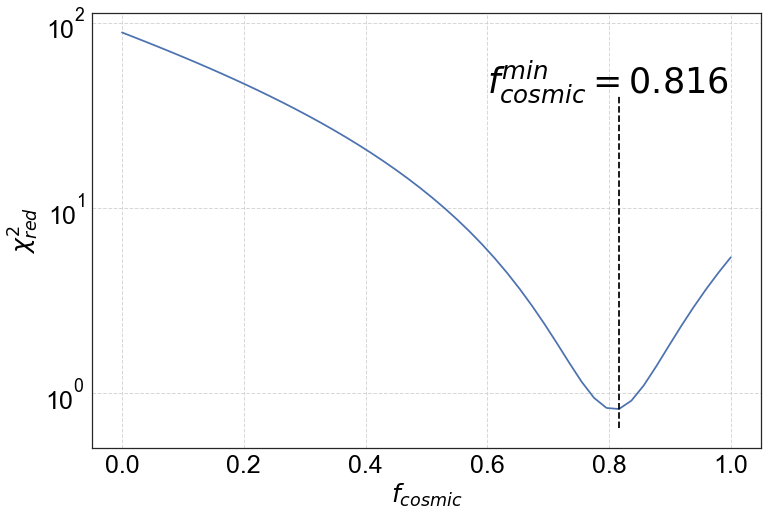

In [88]:
fig,ax=plt.subplots(figsize=(12,8))
plt.plot(f_cosmic_array,chi2_array/ndf)
set_axes(ax,r'$f_{cosmic}$',r'$\chi^2_{red}$',do_add_grid='True')
ax.set_yscale('log')

# best point
i_min = np.argmin(chi2_array)
f_min = f_cosmic_array[i_min]
print 'f_min:',f_min
plt.plot([f_min,f_min],[np.min(ax.get_ylim()),chi2_array[i_min]],'--',color='black')
plt.text(0.6,1.05*chi2_array[i_min],r'$f _{cosmic}^{min} = %.3f$'%f_min,fontsize=35 ,color='black') 
plt.savefig(figures_path+'f_cosmic_vs_chi2_MatchedFlash.pdf')

# and after choosing the optimal $f_{cosmic}$

In [89]:
f_Cosmic=0.816
overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic] = get_samples_scaling( N_total= float(len(reducedOnBeam['MatchedFlash']))
                                                                                    , debug=0
                                                                                    , f_Cosmic=f_Cosmic
                                                                                    , OverlaySubsamples=reducedOverlay['MatchedFlash'])

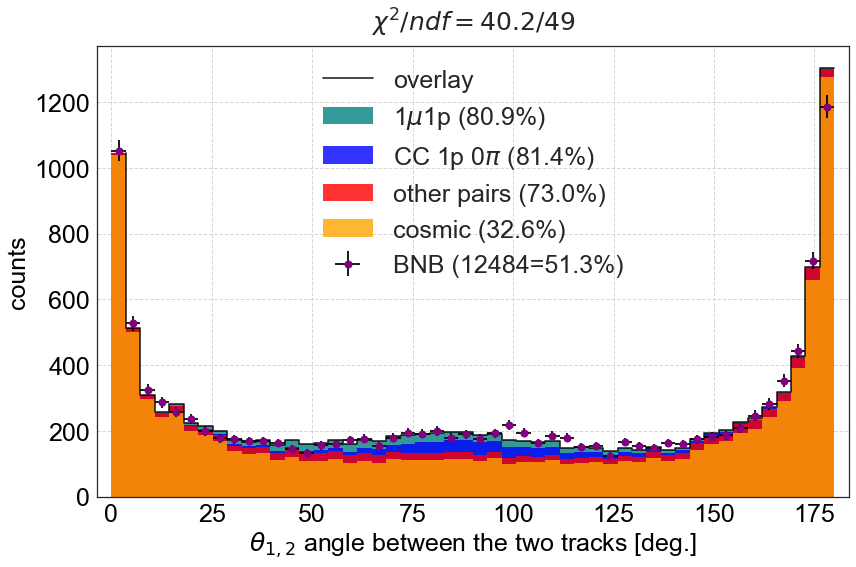

In [90]:
fig,ax=plt.subplots(figsize=(12,8))
h_stack,_=plot_stacked_MCsamples( reducedOverlay=reducedOverlay,cut_name='MatchedFlash'
                       , overlay_scaling=overlay_scalings['N(On) scaling and f(cosmic)=%.2f'%f_Cosmic]
                       , ax=ax, var=var, x_label=x_label,y_label='counts', bins=bins 
                       , fontsize=25                       
                       , stackColor='black',stackLabel='overlay'
                      );
_,h_OnBeam = plot_OnBeam(OnBeamSample=reducedOnBeam['MatchedFlash'],OnBeamFV=OnBeamFV,markersize=8
                                 ,color='purple',x_label=x_label, var=var, bins=bins, ax=ax)
chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                     , h1=h_OnBeam , h2=h_stack
                                     , h1err=np.sqrt(h_OnBeam), h2err=np.sqrt(h_stack)
                                     , debug=0 )
chi2_txt = r'$\chi^2/ndf=%.1f/%d$'%(chi2,ndf)
ax.set_title(chi2_txt,y=1.02,fontsize=25)
ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig(figures_path+'theta_12_overlay_cosmicRescaled_MatchedFlash_with_BeamOn.pdf')